<a href="https://colab.research.google.com/github/khoing-ml/ModifAI/blob/master/ModifAI_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install --quiet gradio

In [1]:
from google.colab import userdata
import os

# Load the secret
HF_TOKEN = userdata.get('HF_TOKEN')

# Set the environment variable
os.environ['HF_TOKEN'] = HF_TOKEN

In [ ]:
import torch
# 1. Import the NEW pipeline class
from diffusers import StableDiffusionXLInpaintPipeline

print("Loading SDXL Inpainting Model...")
# 2. Load the SDXL Inpainting pipeline
pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1", # <-- SDXL inpainting model
    torch_dtype=torch.float16,
    variant="fp16"  # <-- Helps save VRAM on Kaggle
)
pipe = pipe.to("cuda")
print("Model Loaded.")

Loading SDXL Inpainting Model...


model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

In [29]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import requests
from io import BytesIO

def inpaint_image(image_dict, prompt):
    original_image = image_dict['background']
    mask_image = image_dict['layers'][0]

    # --- Data Pre-processing ---
    original_image = original_image.convert("RGB").resize((512, 512))
    mask_image = mask_image.convert("L").resize((512, 512))
    print("Running inpainting...")
    generator = torch.Generator(device="cuda").manual_seed(42)

    result_image = pipe(
        prompt=prompt,
        image=original_image,
        mask_image=mask_image,
        generator=generator,
        strength=1
    ).images[0]

    print("Done!")
    return (result_image, mask_image, original_image)

In [30]:

import gradio as gr

def process_image(image_with_mask):
    # The input 'image_with_mask' is a dictionary
    # {'background': original_image, 'layers': [mask_layer], 'composite': combined_image}

    original = image_with_mask['background']
    mask = image_with_mask['layers'][0] # This is your mask!

    # ... (Here you would call your Stable Diffusion pipeline) ...
    #
    # Faking a result for this demo:
    edited_image = original # Replace with: pipe(prompt=..., image=original, mask_image=mask).images[0]

    return edited_image

# The 'brush' tool is key here
demo = gr.Interface(
    fn=process_image,
    inputs=gr.ImageEditor(
        type="pil",
        sources=["upload"],
        label="Draw a mask on the area you want to change"
    ),
    outputs=gr.Image(label="Result"),
    title="AI Image Inpainting"
)

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://290f04fb0d4342fb00.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7862 <> https://290f04fb0d4342fb00.gradio.live


In [33]:
import pandas as pd
from PIL import Image
import os

# Define the root directory for your flagged data
FLAG_DIR = ".gradio/flagged/"

# 1. Load the CSV log file
try:
    log_df = pd.read_csv(os.path.join(FLAG_DIR, "dataset1.csv"))
    print("Flagged Data Log:")
    print(log_df.head())

except FileNotFoundError:
    print("No flagged data found yet. Click the 'Flag' button in your demo!")

Flagged Data Log:
          Draw a mask on the area you want to change  \
0  {"background": ".gradio/flagged/Draw a mask on...   

                                              Result  \
0  .gradio/flagged/Result/77ac1a856d8abbc0c598/im...   

                    timestamp  
0  2025-11-09 15:43:44.878249  


Loading Original Image: .gradio/flagged/Draw a mask on the area you want to change/0c129a6a32ab7a1dd819/background.png
Loading Mask Image: .gradio/flagged/Draw a mask on the area you want to change/3b3cb3732b13f73b5b0a/layer_0.png

Re-running pipeline with prompt: 'remove the shoes'
Running inpainting...


  0%|          | 0/50 [00:00<?, ?it/s]

Done!
Pipeline finished!


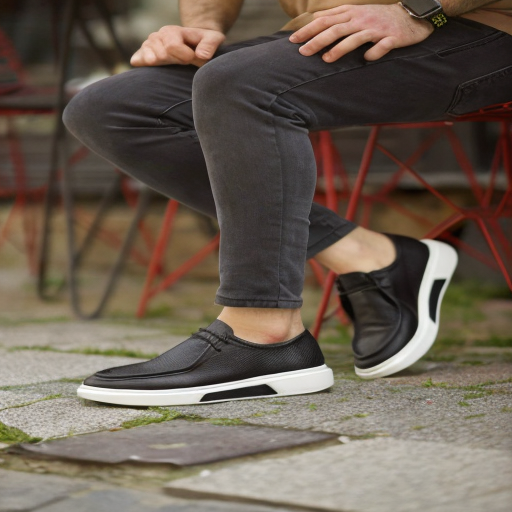

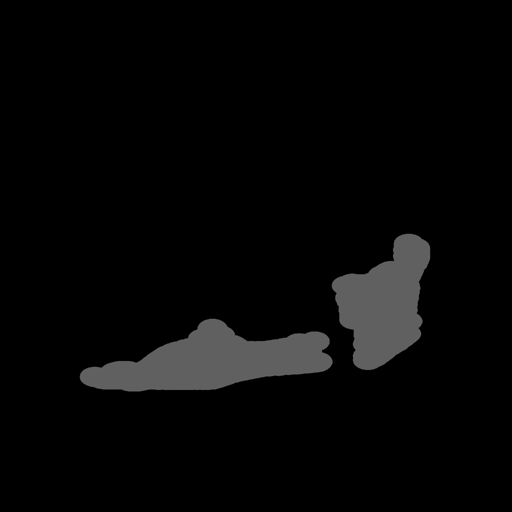

In [34]:
import pandas as pd
import json
from PIL import Image
from IPython.display import display

# --- 1. Define the correct file path ---
log_file_path = ".gradio/flagged/dataset1.csv"

try:
    df = pd.read_csv(log_file_path)
    # --- 2. Define the correct column name from YOUR CSV ---
    # This is the label from your ImageEditor
    image_editor_column_name = "Draw a mask on the area you want to change"

    # --- 3. Get Data from the First Flagged Example (row 0) ---
    example_row = df.iloc[0]

    # --- 4. Get and Parse the ImageEditor JSON string ---
    image_editor_json_string = example_row[image_editor_column_name]
    image_editor_data = json.loads(image_editor_json_string)

    # --- 5. Get the Image Paths from the JSON ---
    original_image_path = image_editor_data['background']
    mask_image_path = image_editor_data['layers'][0] # The mask

    print(f"Loading Original Image: {original_image_path}")
    print(f"Loading Mask Image: {mask_image_path}")

    # --- 6. Load the Images using PIL ---
    original_image = Image.open(original_image_path)
    mask_image = Image.open(mask_image_path)

    # --- 7. Re-run the Pipeline (MANUALLY ADD PROMPT) ---
    image_dict_for_pipeline = {
        'background': original_image,
        'layers': [mask_image]
    }
    prompt = "remove the shoes"  # <--- CHANGE THIS
    print(f"\nRe-running pipeline with prompt: '{prompt}'")
    # Make sure the cell with the 'inpaint_image' function has been run
    rerun_result, mask_image, original_image = inpaint_image(image_dict_for_pipeline, prompt)
    print("Pipeline finished!")

    display(rerun_result) # Display the new result
    display(mask_image) # Display the original image

except FileNotFoundError:
    print(f"Error: Could not find log file at {log_file_path}")
